In [24]:
import os
import sys
import scipy.io
from scipy.io import loadmat

import glob
import cv2

import numpy as np
import matplotlib.pyplot as plt
# from utils import directDeconvolve, od2rgb, rgb2od, display_M
# from utils import  od2rgb, rgb2od, display_M

In [25]:
from skimage.metrics import structural_similarity, peak_signal_noise_ratio

In [26]:

def od2rgb(od):
    rgb=256*np.exp(-od)-1
    return rgb

def rgb2od(rgb):
    od=(-np.log((rgb+1)/256))
    return od

def display_M(M):
    ns=M.shape[1]
    Mdisp=M.T.reshape(1,ns,3)
    Mdisp=od2rgb(Mdisp).astype('int')
    plt.imshow(Mdisp)
    
def get_range(array):
    print('min:',array.min(),'max',array.max(),array.shape)
    
# def rgb2od(rgb):
#     od=(-np.log((rgb+1)/256))
#     return od

# Original image

In [27]:
RGB_dir= '/data/BasesDeDatos/Alsubaie/Data/RGB_images/Lung/2/02/'
patch = cv2.imread(RGB_dir+'02.png')
#CV2 lee en BGR en lugar de RGB
I_GT= cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
#Las redes de Santiago con las que he trabajado hasta ahora usan el formato (3xMxN)
# patch = patch.transpose((2, 0, 1)).astype(np.float32)/255.0
plt.figure(figsize=(10,8))
plt.imshow(I_GT)
print(I_GT.shape,I_GT.dtype)

# Read GROUND TRUTH
#plt.figure()
gt_folder='/data/BasesDeDatos/Alsubaie/Data/GroundTruth/Lung/2/'
M_GT=loadmat(gt_folder+'SV.mat')
M_GT=M_GT['Stains']
M_GT
#display_M(M_GT)
#print(M_GT)

(2000, 2000, 3) uint8


array([[0.51189731, 0.25939384],
       [0.79641632, 0.89226269],
       [0.32199717, 0.36957019]])

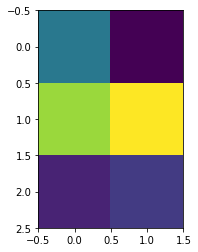

In [28]:
plt.imshow(M_GT)

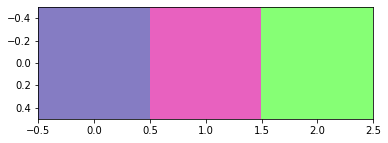

In [29]:
M_RUI=np.array([[0.644211  , 0.092789  , 0.63598099],
       [0.716556  , 0.954111  , 0.        ],
       [0.266844  , 0.283111  , 0.77170472]])
display_M(M_RUI)

In [30]:
get_range(I_GT)

min: 0 max 255 (2000, 2000, 3)


In [31]:
Y_GT= rgb2od(I_GT.astype('float')) 
get_range(Y_GT)
norm_CONST = -np.log(1/256)

Y_GT_norm = Y_GT / norm_CONST
get_range(Y_GT_norm)

min: -0.0 max 5.545177444479562 (2000, 2000, 3)
min: -0.0 max 1.0 (2000, 2000, 3)


# Get concentration ground truth

This is the classical method, here we use Y with range [0, 5.54]

In [32]:
def directDeconvolve(Y,M):
#     I=im2uint(I)
    [m,n,c]=Y.shape
    Y=Y.reshape(-1,c).T # 3xMN
#     Y=rgb2od(Icol)
    CT=np.linalg.lstsq(M,Y,rcond=None)[0]
    return CT
def display_C(C):
    H=C[0,:].reshape(2000,2000)
    E=C[1,:].reshape(2000,2000)
    plt.figure(figsize=(15,10))
    plt.subplot(121)
    plt.imshow(H.T,cmap='gray')
    plt.subplot(122)
    plt.imshow(E.T,cmap='gray')
    
def display_C_rgb(C,M):
    ns=C.shape[0]
    plt.figure(figsize=(15,10))
    
    for i in range(ns):
        S_od= np.dot(M[:,i].reshape(3,1),C[i,:].reshape(1,-1))
        S_rgb = od2rgb(S_od).astype('int')
        S_rgb=S_rgb.reshape(3,2000,2000).T
        plt.subplot(1,ns,i+1)
        plt.imshow(S_rgb)
        


In [33]:
C_GT= directDeconvolve(Y_GT.astype('float'),M_GT)
get_range(C_GT)

min: -1.8408485377600425 max 8.659195708936055 (2, 4000000)


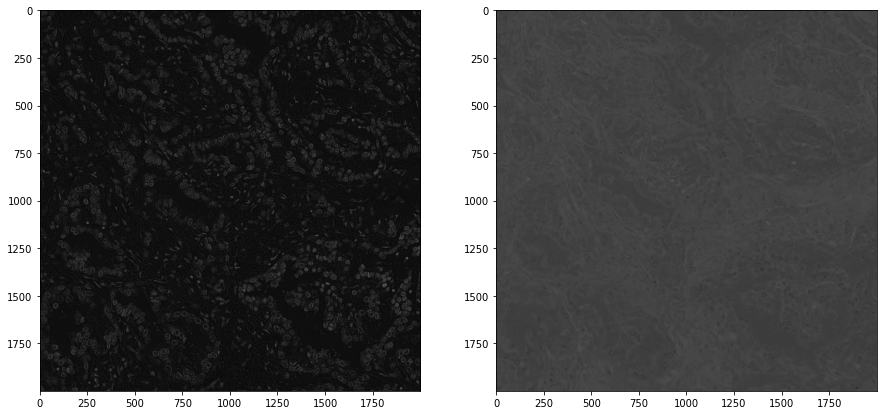

In [34]:
display_C(C_GT)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


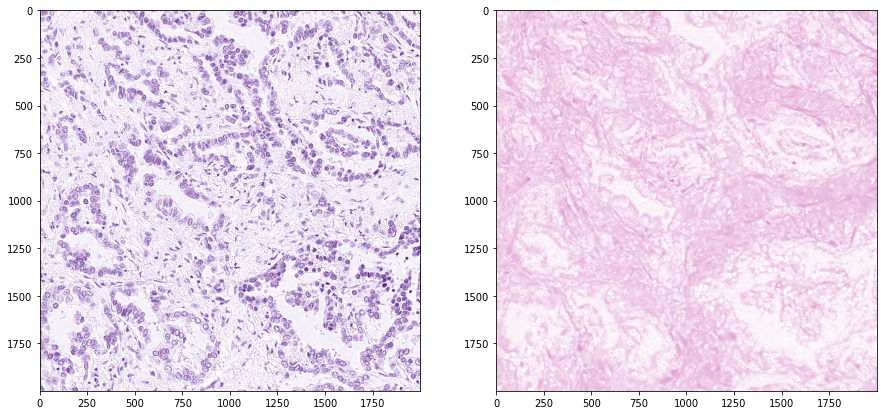

In [35]:
display_C_rgb(C_GT,M_GT)

min: -0.0019397813684818234 max 5.699579991409103 (3, 4000000)
min: 0 max 255 (2000, 2000, 3)


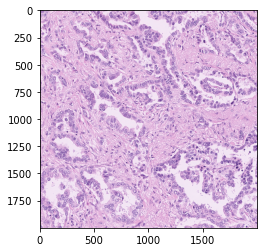

In [36]:
Y_rec=np.dot(M_GT,C_GT) # (3,2) x (2,MN)
get_range(Y_rec)
I_rec=od2rgb(Y_rec).astype('int')
I_rec=I_rec.reshape(3,2000,2000).T
get_range(I_rec)
plt.imshow(I_rec)

In [37]:
np.linalg.norm(Y_GT-Y_rec.reshape(3,2000,2000).T)/Y_rec.size



8.653447000943123e-05

# Get concentration with Y_norm [0,1]

In [38]:
C_GT_norm= directDeconvolve(Y_GT_norm.astype('float'),M_GT)
get_range(C_GT_norm)

#get normal C

C_GT = C_GT_norm*norm_CONST
get_range(C_GT)

min: -0.33197288205676434 max 1.5615723384211304 (2, 4000000)
min: -1.8408485377600436 max 8.659195708936059 (2, 4000000)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


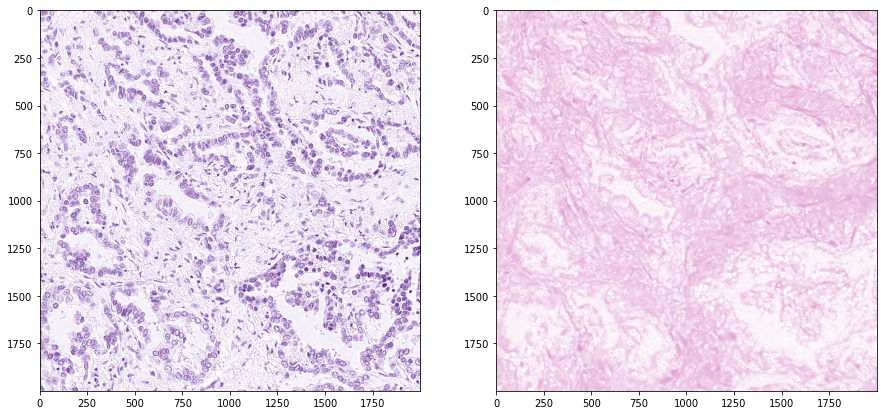

In [39]:
display_C_rgb(C_GT,M_GT)

min: -0.0019397813684819088 max 5.699579991409103 (3, 4000000)
min: 0 max 255 (2000, 2000, 3)


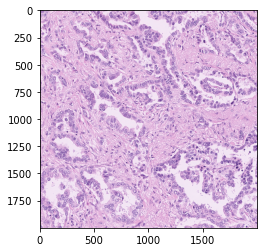

In [40]:
Y_rec=np.dot(M_GT,C_GT) # (3,2) x (2,MN)
get_range(Y_rec)
I_rec=od2rgb(Y_rec).astype('int')
I_rec=I_rec.reshape(3,2000,2000).T
get_range(I_rec)
plt.imshow(I_rec)

# Now, we do the same with the C and M obtained with the network

In [41]:
example_dir='/work/work_ysw/Deblur_Code/test_result/RGB_images/Lung/2/02/'

m_h=loadmat(example_dir+'m_h_epoch100.mat')['m_h_result'][0,:]
m_h
m_e=loadmat(example_dir+'m_e_epoch100.mat')['m_e_result'][0,:]
m_e

M_read=np.zeros([2,3])
M_read[0,:]=m_h
M_read[1,:]=m_e
M_net= M_read.T

display_M(M_net)
print(M_net)

FileNotFoundError: [Errno 2] No such file or directory: '/work/work_ysw/Deblur_Code/test_result/RGB_images/Lung/2/02/m_h_epoch100.mat'

In [ ]:
C_read=loadmat(example_dir+'c_epoch100.mat')['c_result']
get_range(C_read)
C_norm=C_read.reshape(2,-1)
C_net=C_norm*norm_CONST
get_range(C_net)
display_C(C_net)

In [ ]:
display_C_rgb(C_net,M_net)

In [ ]:
Y_rec=np.dot(M_net,C_net) # (3,2) x (2,MN)
get_range(Y_rec)
I_rec=od2rgb(Y_rec).astype('int')
I_rec=I_rec.reshape(3,2000,2000).T
get_range(I_rec)
plt.imshow(I_rec)

In [ ]:
np.linalg.norm(Y_GT-Y_rec.reshape(3,2000,2000).T)/Y_rec.size



# Something is wrong

Let see the expected value for C when we have M_net by doing the direct deconvolution

In [ ]:
C_expected=  directDeconvolve(Y_GT.astype('float'),M_net)
get_range(C_expected)
display_C(C_expected)
display_C_rgb(C_expected,M_net)

In [ ]:
plt.figure(figsize=(15,10))
n,bins,patches=plt.hist(C_GT.T, color=['b','r'], bins=255)
plt.title('Ground Truth')
plt.show()
plt.figure(figsize=(15,10))
n,bins,patches=plt.hist(C_net.T, color=['b','r'], bins=255)
plt.title('Cnet')
plt.show()
plt.figure(figsize=(15,10))
n,bins,patches=plt.hist(C_norm.T, color=['b','r'], bins=255)
plt.title('Cnorm')
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
n,bins,patches=plt.hist(C_expected.T, color=['b','r'], bins=255)
plt.title('C_expected')
plt.show()

In [ ]:
C_v2= C_net.copy()
for i in range(C_net.shape[0]):
    C_v2[i,:]=C_net[i,:]-np.mean(C_net[i,:])
C_v2= C_v2*norm_CONST

In [ ]:
plt.figure(figsize=(15,10))
n,bins,patches=plt.hist(C_v2.T, color=['b','r'], bins=255)
plt.title('C_v2')
plt.show()

In [ ]:
display_C(C_v2)
display_C_rgb(C_v2,M_net)

In [ ]:
Y_rec=np.dot(M_net,C_v2) # (3,2) x (2,MN)
get_range(Y_rec)
I_rec=od2rgb(Y_rec).astype('int')
I_rec=I_rec.reshape(3,2000,2000).T
get_range(I_rec)
plt.imshow(I_rec)
print(np.linalg.norm(Y_GT-Y_rec.reshape(3,2000,2000).T)/Y_rec.size)



# Check the quality using PSNR and SSIM

Following previous works, we will calculate PSNR and SSIM on the separated RGB images for H and E.

In [ ]:
def get_C_rgb(C,M):
    ns=C.shape[0]
    patch_size=np.sqrt(C.shape[1]).astype('int')
    all_images= np.zeros([ns,patch_size,patch_size,3],dtype='uint8')
    for i in range(ns):
        S_od= np.dot(M[:,i].reshape(3,1),C[i,:].reshape(1,-1))
        S_rgb = np.clip(od2rgb(S_od),0,255).astype('uint')
        S_rgb=S_rgb.reshape(3,patch_size,patch_size).T
        get_range(S_rgb)
        all_images[i,:,:,:] = S_rgb
    return all_images

In [ ]:
all_images=get_C_rgb(C_expected,M_net)

In [ ]:
stains_GT = get_C_rgb(C_GT,M_GT)

In [ ]:
plt.subplot(121),plt.imshow(all_images[0,:,:,:].astype('int'))
plt.subplot(122),plt.imshow(all_images[1,:,:,:].astype('int'))

In [ ]:
all_images=get_C_rgb(C_expected,M_net)
print('EXPECTED')
psnr_H=peak_signal_noise_ratio(stains_GT[0,:,:,:],all_images[0,:,:,:])
psnr_E=peak_signal_noise_ratio(stains_GT[1,:,:,:],all_images[1,:,:,:])
print('PSNR',psnr_H,psnr_E)

ssim_H=structural_similarity(stains_GT[0,:,:,:],all_images[0,:,:,:],multichannel=True)
ssim_E=structural_similarity(stains_GT[1,:,:,:],all_images[1,:,:,:],multichannel=True)

print('SSIM',ssim_H,ssim_E)

In [ ]:
print('NETWORK')
all_images=get_C_rgb(C_net,M_net)
psnr_H=peak_signal_noise_ratio(stains_GT[0,:,:,:],all_images[0,:,:,:])
psnr_E=peak_signal_noise_ratio(stains_GT[1,:,:,:],all_images[1,:,:,:])
print('PSNR',psnr_H,psnr_E)

ssim_H=structural_similarity(stains_GT[0,:,:,:],all_images[0,:,:,:],multichannel=True)
ssim_E=structural_similarity(stains_GT[1,:,:,:],all_images[1,:,:,:],multichannel=True)

print('SSIM',ssim_H,ssim_E)

In [ ]:
print('MANUALLY CORRECTED')
all_images=get_C_rgb(C_v2,M_net)
psnr_H=peak_signal_noise_ratio(stains_GT[0,:,:,:],all_images[0,:,:,:])
psnr_E=peak_signal_noise_ratio(stains_GT[1,:,:,:],all_images[1,:,:,:])
print('PSNR',psnr_H,psnr_E)

ssim_H=structural_similarity(stains_GT[0,:,:,:],all_images[0,:,:,:],multichannel=True)
ssim_E=structural_similarity(stains_GT[1,:,:,:],all_images[1,:,:,:],multichannel=True)

print('SSIM',ssim_H,ssim_E)


